**Programmer:** python_scripts (Abhijith Warrier)

**PYTHON SCRIPT TO **_SELECT TOP-k FEATURES WITH `SelectKBest` AND BUILD A CLEAN CLASSIFICATION PIPELINE._** 🐍🧪📊**

This script shows how to use **univariate feature selection** with the **ANOVA F-test** (`f_classif`) to keep the most informative features, avoid overfitting, and simplify your model. We’ll fit a pipeline: **SelectKBest → LogisticRegression**, evaluate performance, and inspect which features were kept.

### 📦 Import Libraries
We’ll use scikit-learn for dataset, feature selection, modeling, and metrics. Matplotlib/Pandas for reporting.

In [1]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### 📥 Load Tabular Dataset
Using the **Breast Cancer Wisconsin** dataset (binary classification).
We’ll keep feature names for easy interpretation later.

In [2]:
data = load_breast_cancer()
X, y = data.data, data.target
feature_names = np.array(data.feature_names)  # numpy array for easy indexing

print(f"X shape: {X.shape} | y shape: {y.shape}")
print("Classes:", list(data.target_names))

X shape: (569, 30) | y shape: (569,)
Classes: [np.str_('malignant'), np.str_('benign')]


### ✂️ Train/Test Split (Stratified)
Hold out a test set; stratification preserves class balance.

In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

### 🔎 Configure `SelectKBest` (ANOVA F-test)
- `f_classif` performs a univariate ANOVA F-test **per feature** for classification.
- We’ll select the **top k** features (set `k=10` as a starting point).
> Best practice: put selection **inside a Pipeline** so it’s fit **only on training data** (no leakage).

In [4]:
k = 10  # choose how many features to keep

pipe = Pipeline(steps=[
    ("scaler", StandardScaler()),  # scale numeric features (helps LR)
    ("select", SelectKBest(score_func=f_classif, k=k)),  # select top-k by ANOVA F
    ("clf", LogisticRegression(max_iter=200, random_state=42))
])

### 🚀 Train the Pipeline
`fit()` will: scale → score & select top-k (on train only) → fit classifier.

In [5]:
pipe.fit(X_train, y_train)

,steps,"[('scaler', ...), ('select', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,score_func,<function f_c...t 0x117774a40>
,k,10
,penalty,'l2'
,dual,False


### 🔮 Evaluate on Test Set
Use the same pipeline to transform test data and predict with the trained model.

In [6]:
y_pred = pipe.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {acc:.4f}\n")
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=data.target_names))

Test Accuracy: 0.9510

Classification Report:
               precision    recall  f1-score   support

   malignant       0.94      0.92      0.93        53
      benign       0.96      0.97      0.96        90

    accuracy                           0.95       143
   macro avg       0.95      0.95      0.95       143
weighted avg       0.95      0.95      0.95       143



### 🧾 Inspect Selected Features & Scores
Pull the **F-scores** from the fitted selector and see which features were kept.

In [7]:
# Access the fitted SelectKBest step
selector = pipe.named_steps["select"]

# Boolean mask of selected features in ORIGINAL order
mask = selector.get_support()

# Scores for all features (align with feature_names)
scores = selector.scores_

# Build a table of (feature, score, selected) and sort by score
report_df = pd.DataFrame({
    "feature": feature_names,
    "f_score": scores,
    "selected": mask
}).sort_values("f_score", ascending=False)

print("Top features by ANOVA F-score:")
report_df.head(15)

Top features by ANOVA F-score:


,feature,f_score,selected
27,worst concave points,736.818364,True
7,mean concave points,675.650028,True
22,worst perimeter,661.444639,True
20,worst radius,634.139063,True
2,mean perimeter,530.656609,True
23,worst area,499.119290,True
0,mean radius,491.371838,True
3,mean area,441.363153,True
6,mean concavity,389.916976,True
26,worst concavity,339.345752,True


### 📊 Visualize Top-k Feature Scores
Bar chart of the **k** best features chosen by `SelectKBest`.

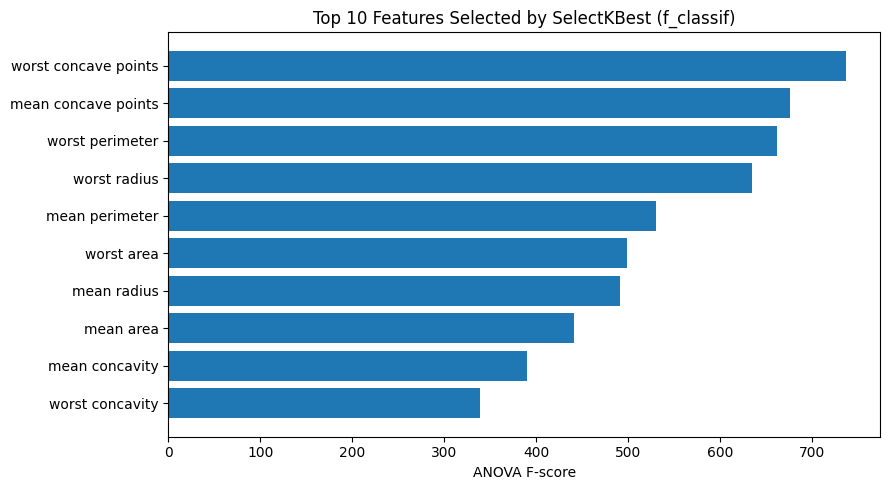

In [8]:
topk_df = report_df[report_df["selected"]].copy()
plt.figure(figsize=(9, 5))
plt.barh(topk_df["feature"], topk_df["f_score"])
plt.gca().invert_yaxis()
plt.xlabel("ANOVA F-score")
plt.title(f"Top {k} Features Selected by SelectKBest (f_classif)")
plt.tight_layout()
plt.show()

### 📝 Notes & Tips
- **Choosing k:** Try several values (e.g., 5, 10, 15) and compare CV/test scores.
- **Scoring function:** For classification, `f_classif` is common; for regression, use `f_regression`.
- **Pipelines prevent leakage:** Selection is learned on **train only**, then applied to test.
- **Alternatives:** `SelectPercentile`, `mutual_info_classif`, model-based selection (`SelectFromModel` with L1 or trees).
- **Caveat:** Univariate tests ignore feature interactions; consider wrapper/embedded methods if interactions matter.